# Fast Food Marketing Campaign A/B Test Analysis

## 1. Goal of the analysis

1. **Effectiveness of Marketing Strategies:**
- **Hypothesis:** Promotion 1 and Promotion 3 are more effective in sales compared to Promotion 2, as suggested by higher median and mean sales values.

2. **Statistical Significance of Sales Differences:**
- **Hypothesis:** Differences in sales between promotions are statistically significant, allowing us to identify the most effective promotion.

3. **Market-Specific Variations:**
- **Hypothesis:** Variations in sales by promotion are consistent across markets, and market characteristics do not significantly alter the promotion effectiveness.

4. **Sample Ratio Consistency:**
- **Hypothesis:** There is no sample ratio mismatch (SRM) in the dataset, ensuring that statistical tests yield reliable results.

5. **Distributional and Variance Assumptions:**
- **Hypothesis:** Sales data for each promotion meet assumptions for normality and variance equality, allowing for valid statistical comparisons.


### 1.1 Context and Description:

In this project, we aim to evaluate the effectiveness of three different marketing strategies to promote a new item at a fast-food chain. Each promotion was introduced at locations in randomly selected markets, and weekly sales data for the new item were recorded over the first four weeks. By comparing the sales data for each promotion, we seek to determine which marketing campaign has the greatest impact on sales and thus choose the most effective promotion.

By addressing these aspects, the analysis aims to provide actionable insights for the **marketing and strategy teams** of the fast-food chain to determine the most effective promotion strategy. These findings will guide decision-making regarding future campaigns to maximize revenue.

### 1.2. Target Metric:

The target metric for this A/B test is **mean sales** of the new item, measured in thousands of dollars. This metric shows how well each promotion drives sales, helping us identify which promotion is most effective in boosting revenue for the new product. The promotion that will have the highest average sales over the four-week period is considered the most successful.

### 1.3 First, we import the main libraries and create a consistent visual colormap we will use for the analysis.

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from scipy.stats import f_oneway, levene
from statsmodels.stats.multicomp import pairwise_tukeyhsd

from utilities import (find_missing_values, find_outliers, calculate_summary,
                       plot_sales_data, plot_market_sales_data,
                       plot_sales_distribution, get_variant_summary,
                       get_srm, plot_promotion_histograms)

In [2]:
pd.set_option('display.max_colwidth', None)
plt.rcParams['figure.figsize'] = (10, 6)
colors=["#ca0020", "#f4a582", "#92c5de", "#0571b0"]
sns.set_theme(style="white")
sns.set_palette(sns.color_palette(colors))

## 2. Cleaning and inspecting data

### 2.1 We import the dataset and take a look at it

In [3]:
df = pd.read_csv("WA_Marketing-Campaign.csv")
df.head()

,MarketID,MarketSize,LocationID,AgeOfStore,Promotion,week,SalesInThousands
0,1,Medium,1,4,3,1,33.73
1,1,Medium,1,4,3,2,35.67
2,1,Medium,1,4,3,3,29.03
3,1,Medium,1,4,3,4,39.25
4,1,Medium,2,5,2,1,27.81


### 2.2 We check for any missing values

In [4]:
find_missing_values(df)

,Zeroes,Empty Strings,NaN
MarketID,0,0,0
MarketSize,0,0,0
LocationID,0,0,0
AgeOfStore,0,0,0
Promotion,0,0,0
week,0,0,0
SalesInThousands,0,0,0


Seems like there are no missing values - great!

### 2.3 We check for any duplicate entries

In [5]:
print(f"There are {df.duplicated().sum()} duplicate rows.")

There are 0 duplicate rows.


### 2.4 We check the datatypes

In [6]:
df.dtypes

MarketID              int64
MarketSize           object
LocationID            int64
AgeOfStore            int64
Promotion             int64
week                  int64
SalesInThousands    float64
dtype: object

In [7]:
df = df.astype({"MarketSize": "category", "Promotion": "category"})

Since MarketSize represents distinct categories, we will convert it to categorical data. As each number in promotion represents a distinct promotion, we will also convert it to categorical data.

### 2.5 Let's check for any outliers in numerical fields using the IQR method

In [8]:
numeric = [feature for feature in df if df[feature].dtype in ["int64","float64"]]
outliers = find_outliers(df,numeric)
print(f"Outliers:\n{outliers}")

No outliers in 'MarketID'
No outliers in 'LocationID'
Outliers in 'AgeOfStore':
192    28
193    28
194    28
195    28
204    25
205    25
206    25
207    25
392    27
393    27
394    27
395    27
Name: AgeOfStore, dtype: int64

No outliers in 'week'
Outliers in 'SalesInThousands':
80     88.73
83     94.17
84     89.70
88     87.43
90     88.12
93     90.30
95     89.77
99     88.91
100    87.70
103    94.21
104    96.48
106    91.98
108    93.71
109    96.01
110    93.03
111    97.61
113    88.07
114    94.43
115    89.44
116    88.64
121    87.90
128    91.60
130    93.86
136    94.89
138    93.63
140    91.61
144    99.65
145    88.64
147    89.25
153    89.32
154    99.12
160    93.32
163    91.29
Name: SalesInThousands, dtype: float64

Outliers:
     MarketID  LocationID  AgeOfStore  week  SalesInThousands
192         4         308          28     1             51.87
193         4         308          28     2             58.01
194         4         308          28     3      

In [9]:
df.describe()

,MarketID,LocationID,AgeOfStore,week,SalesInThousands
count,548.000000,548.000000,548.000000,548.000000,548.000000
mean,5.715328,479.656934,8.503650,2.500000,53.466204
std,2.877001,287.973679,6.638345,1.119055,16.755216
min,1.000000,1.000000,1.000000,1.000000,17.340000
25%,3.000000,216.000000,4.000000,1.750000,42.545000
50%,6.000000,504.000000,7.000000,2.500000,50.200000
75%,8.000000,708.000000,12.000000,3.250000,60.477500
max,10.000000,920.000000,28.000000,4.000000,99.650000


We have some outliers in store age - seems like most stores in our dataset are relatively new, therefore some stores that were open for nearly 3 decades are detected as outliers. As for sales, it seems like sales above ~87k are considered outliers, since 75% of our sales data falls under 60.5k. This data is fine and we will not do anything with the outliers.

### 2.6 What is the locations distribution between markets?

In [10]:
print(df['MarketID'].value_counts())

MarketID
3     88
10    80
7     60
5     60
6     60
1     52
8     48
9     40
4     36
2     24
Name: count, dtype: int64


We can see a wide range of distribution between markets. If needed, we can use this information later on to stratify our data and try to discover any more findings.

### 2.7 Let's look at the sales distribution by promotion

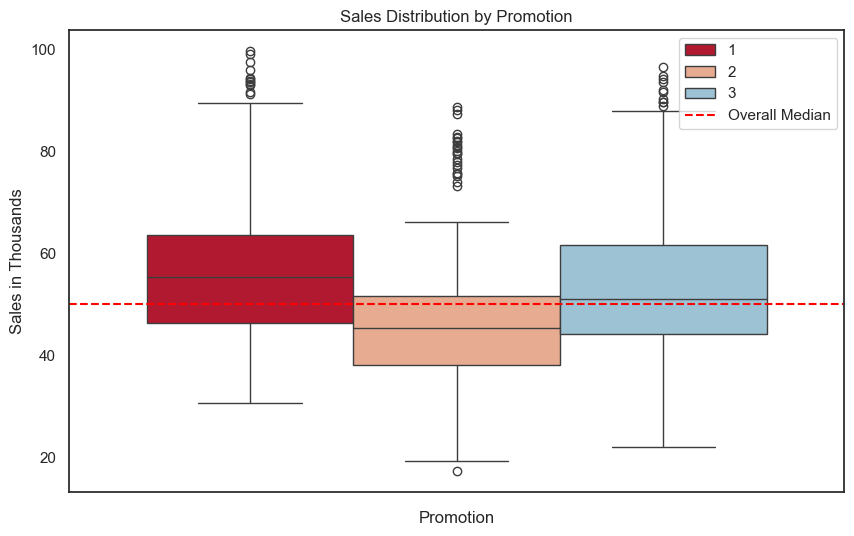

In [11]:
plot_sales_distribution(df)

Initially, we can see that promotions 1 and 3 have a significantly higher median than promotion 2. We also see the beforementioned outliers in higher sales. To determine whether there is statistically significant difference between these promotions, and to understand these numbers in our target metric's mean values, we will have to perform some statistical calculations.

## 3. Calculations

### 3.1 What is our sample size and what are the promotion variation proportions?

In [12]:
total_samples, variant_counts, summary = get_variant_summary(df,"Promotion")
summary

Total Sample Size: 548



,Sample Size,Proportion
Promotion,,
1,172,31.386861
2,188,34.306569
3,188,34.306569


We can see a slight difference in promotion sample sizes (promotion 1 has smaller sample than promotions 2 and 3). To check whether this discrepancy is due to randomness or a bug, we will use the **Chi-Square test**.

### 3.2 Testing for SRM (sample ratio mismatch) using the **Chi-Square test** (using α level of 5%)

In [13]:
get_srm(total_samples, variant_counts)

Chi-Square statistic: 0.93
P-value: 0.6268
The p-value is greater than 0.05, indicating no significant sample ratio mismatch.


Since there is no significant sample ratio mismatch, we can proceed with analyzing the effect of the marketing promotion on sales.

### 3.3 Performing statistical tests on promotion groups

**H0 (Null Hypothesis)**: μ1 = μ2 = μ3 (There is no statistically significant difference in the mean sales across the promotions)

**Ha (Alternative Hypothesis)**: At least one promotion has a statistically significantly different mean in sales.

**α = 0.05 (5%)**

### 3.4 Checking assumptions:
- We imply that observations are independent of one another (due to the nature of our dataset)
- Data normality - data in each group should be normally distributed (less critical with a large enough sample size)
- Variances in each group should be roughly equal

#### 3.4.1 Checking for data normality

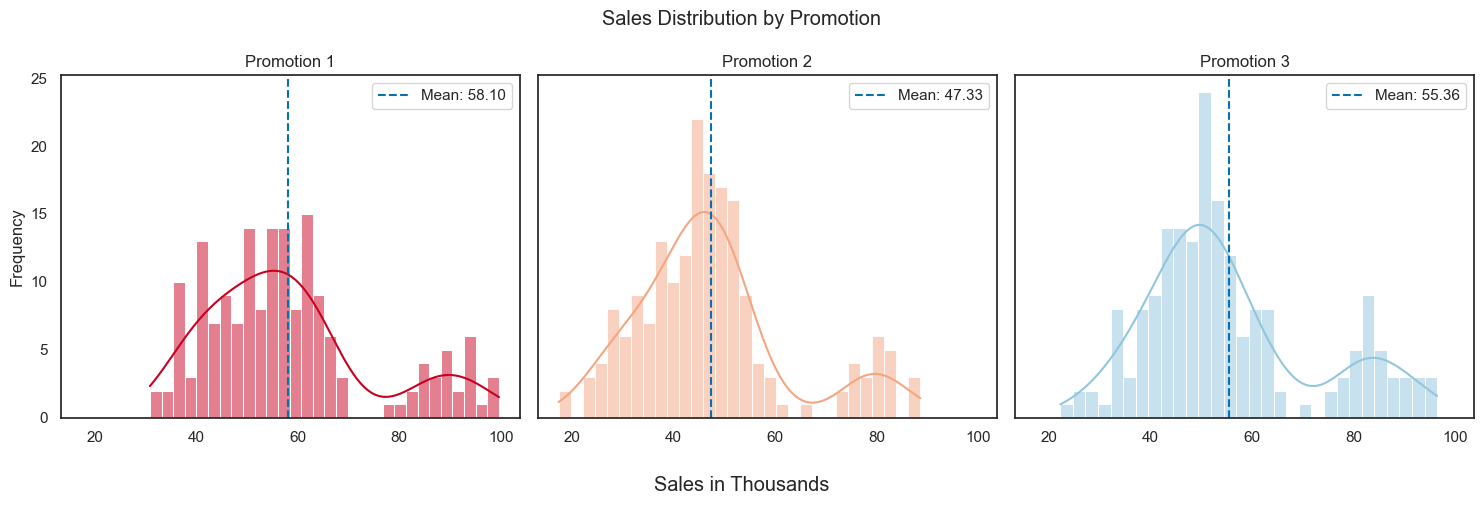

In [14]:
plot_promotion_histograms(df)

Our data does not seem to follow a fully normal distribution. Each promotion follows a slightly bimodal distribution with some skewness to the right. However, we can rely on **Central Limit Theorem** since our sample size for each promotion is large enough (n>30), therefore our assumption still holds.

#### 3.4.2 To check whether the variance between promotions is equal (H0 = population variances are equal), we will use **Levene's test**:

In [15]:
sales_promotion_1 = df[df["Promotion"] == 1]["SalesInThousands"]
sales_promotion_2 = df[df["Promotion"] == 2]["SalesInThousands"]
sales_promotion_3 = df[df["Promotion"] == 3]["SalesInThousands"]

levene_stat, p_value = levene(sales_promotion_1, sales_promotion_2, sales_promotion_3)
print(f"Levene's Test: F-statistic = {levene_stat:.4f}, p-value = {p_value:.4f}")

Levene's Test: F-statistic = 1.2697, p-value = 0.2818


Using Levene's test (used to assess the equality of variances for a variable calculated for two or more groups) we fail to reject the null hypothesis that the variances of promotions are equal, since the **p-value** is above our alpha of 0.05.

Now, all of our assumptions were met and we can continue. We will use **ANOVA** test, which is used to analyze the difference between the means of more than two groups.

### 3.5 Using **ANOVA (Analysis of Variance) test** we calculate the p-value for our hypothesis

In [16]:
alpha = 0.05

f_stat, p_value = f_oneway(sales_promotion_1, sales_promotion_2, sales_promotion_3)
print(f"F-statistic: {f_stat:.2f}")
print(f"P-value: {p_value:.4f}")

if p_value < alpha:
    print(f"The p-value is less than {alpha}, we reject the null hypothesis, indicating significant differences in mean sales across promotions.")
else:
    print(f"The p-value is greater than {alpha}, we fail to reject the null hypothesis, indicating no significant differences in mean sales across promotions.")

F-statistic: 21.95
P-value: 0.0000
The p-value is less than 0.05, we reject the null hypothesis, indicating significant differences in mean sales across promotions.


Since there is a significant difference in mean sales across promotions, we will need to do post-hoc testing to determine which promotions differ from one another. For that, we can use **Tukey's HSD test**, which works well with multiple treatment comparisons.

### 3.6 Using **TukeyHSD (Tukey’s Honestly-Significant Difference) test** to determine promotion differences

In [17]:
tukey_results = pairwise_tukeyhsd(df["SalesInThousands"], df["Promotion"], alpha)
print(tukey_results)

 Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower    upper  reject
-----------------------------------------------------
     1      2 -10.7696    0.0 -14.7738 -6.7654   True
     1      3  -2.7345 0.2444  -6.7388  1.2697  False
     2      3   8.0351    0.0   4.1208 11.9493   True
-----------------------------------------------------


For promotions 1 and 2, the **mean difference** in sales was ~10.8k (promotion 1 having a higher mean), with a **95% CI** between ~14.8k and ~6.8k. With a very low **p-value**, we **reject** the null hypothesis - there is a significant difference between these promotions.

For promotions 1 and 3, the **mean difference** in sales was ~2.7k (promotion 1 having a higher mean), with a **95% CI** between ~6.7k and ~-1.3k. With a high **p-value** of 0.244, we **fail to reject** the null hypothesis - there is no significant difference between these promotions.

For promotions 2 and 3, the **mean difference** in sales was ~8k (promotion 3 having a higher mean), with a **95% CI** between ~4.1k and ~12k. With a very low **p-value**, we **reject** the null hypothesis - there is a significant difference between these promotions.

### 3.7 We can look at the mean sales by promotion with 95% Confidence Intervals:

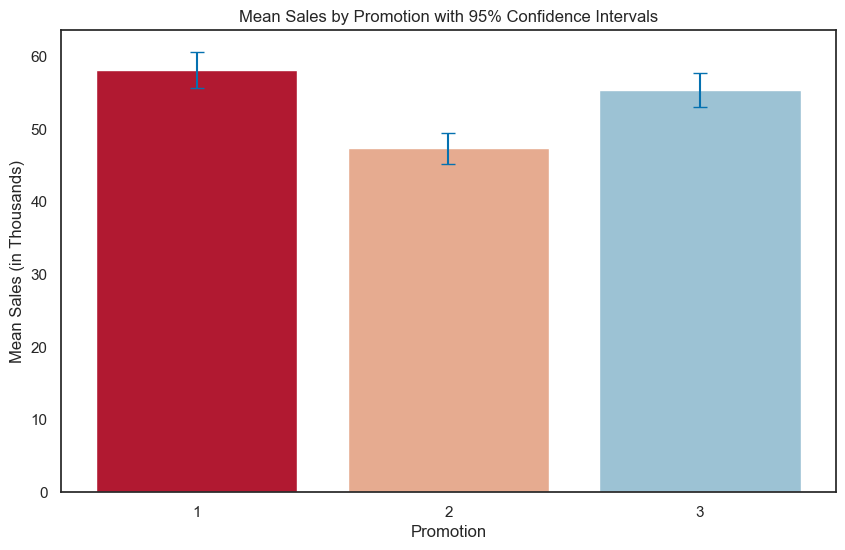

,Promotion,metric,mean,MoE,lower_ci,upper_ci,std,count
0,1,SalesInThousands,58.099012,2.473939,55.625072,60.572951,16.553782,172
1,2,SalesInThousands,47.329415,2.159790,45.169625,49.489205,15.108955,188
2,3,SalesInThousands,55.364468,2.396694,52.967774,57.761162,16.766231,188


In [18]:
sales_summary = calculate_summary(df,["Promotion"],["SalesInThousands"])
plot_sales_data(sales_summary)
sales_summary

As we saw in Tukey test results, promotions 1 and 3 have similar mean values with no statistically significant difference. Promotion 2's mean value is significantly different from promotions 1 and 3, which is also visible in this graph.

- Promotion 1's sales **95% CI** is between ~55.63k and ~60.57k, with mean at ~58.1k.
- Promotion 2's sales **95% CI** is between ~45.17k and ~49.49k, with mean at ~47.3k.
- Promotion 3's sales **95% CI** is between ~52.97k and ~57.76k, with mean at ~55.4k.

### 3.8 We can stratify the data by markets and see if there are any mean differences worth noting.

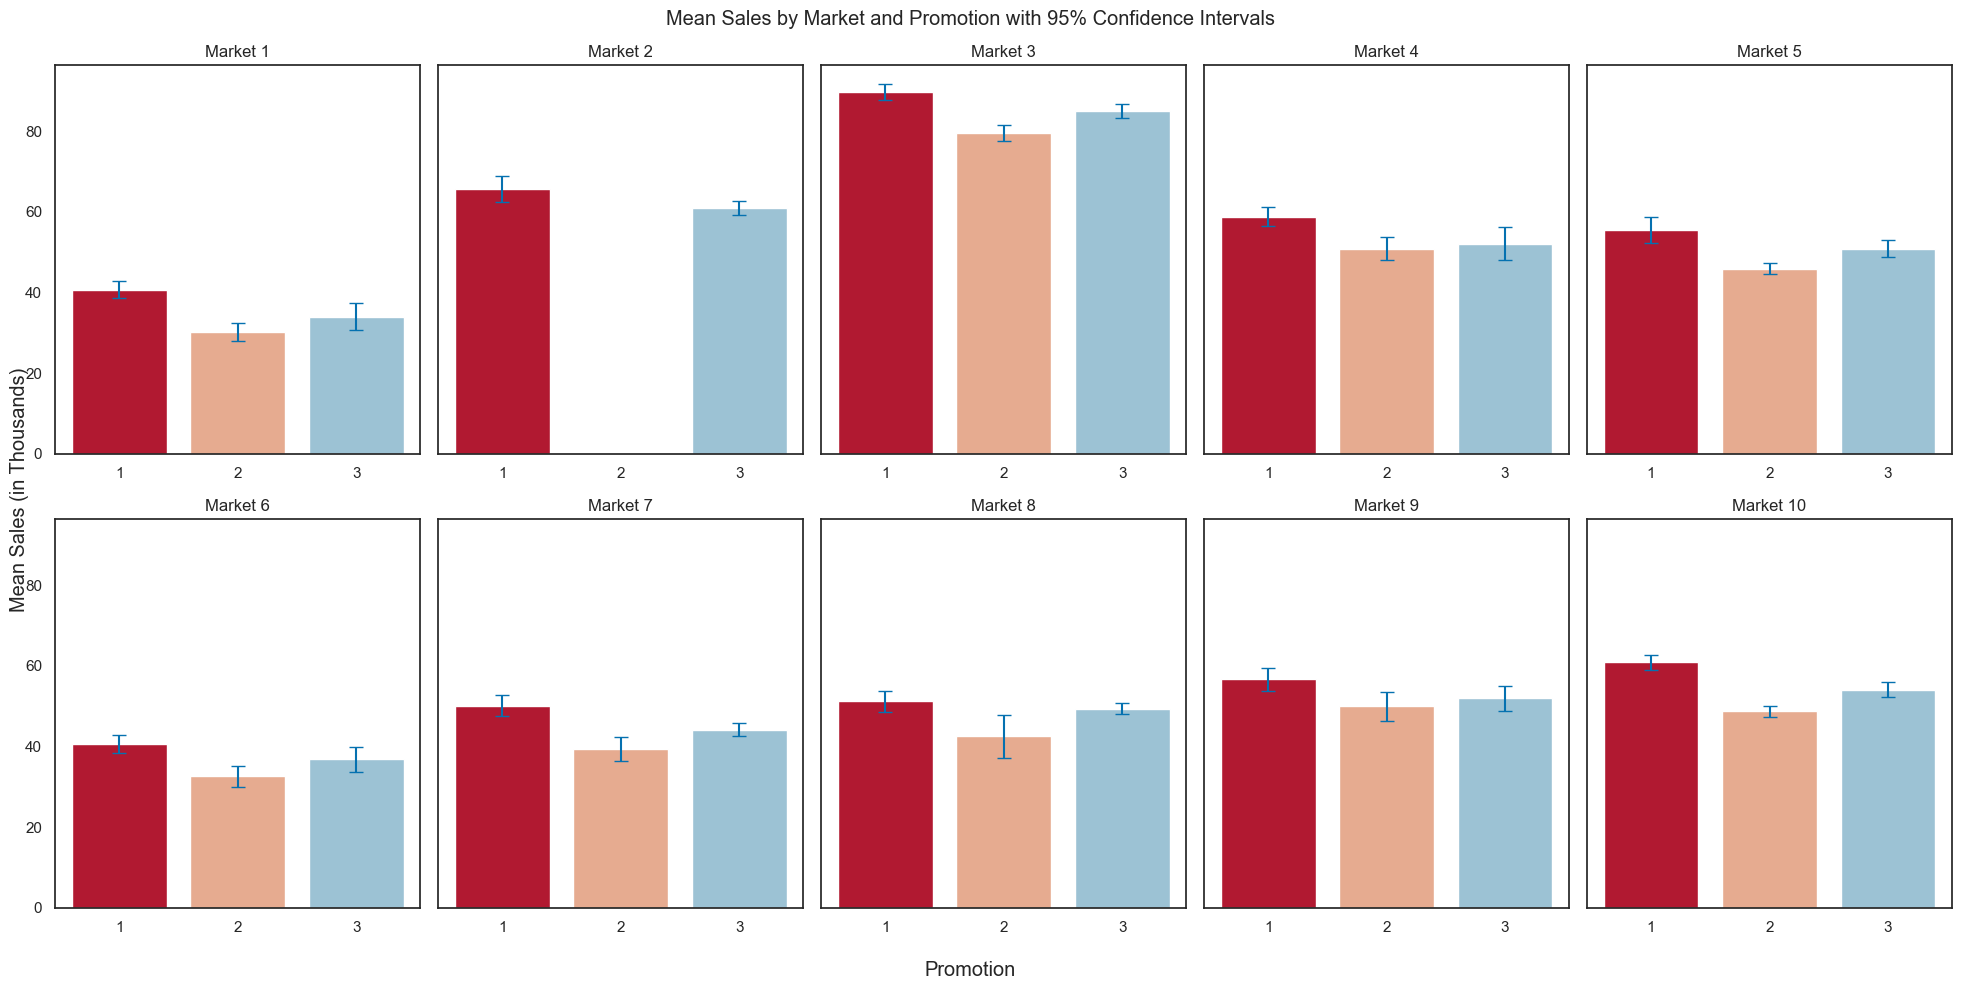

In [19]:
market_summary = calculate_summary(df,["MarketID","Promotion"],["SalesInThousands"])
plot_market_sales_data(market_summary)

While we do see some variation in mean differences between markets (for example promotions 2 and 3 having very similar means in some cases), we cannot conduct statistical tests for any significant results, since our sample sizes in each market are too small. Furthermore, an interesting observation is that Market 2 did not have any cases where promotion 2 was used.

## 4. Decision

- **Promotion 1** is the most effective campaign overall, as it achieves the highest mean sales and significantly outperforms **promotion 2**.
- While **promotion 1** and **promotion 3** have similar average sales (not statistically different), **promotion 1’s** slight edge makes it the safest choice (however, since they can be considered equally effective based on current data, further testing may provide more accurate results)
- **Promotion 2** is the least effective strategy and should not be prioritized.

1. **Sample Ratio Mismatch (SRM):**

- The Chi-Square test yielded a statistic of 0.93 and a p-value of 0.6268.
- Since the p-value > 0.05, there is no significant sample ratio mismatch, and the sample proportions for the promotions are not statistically different.

2. **Promotion Group Comparisons:**

- ANOVA Test Results: The p-value for comparing mean sales across all promotions is statistically significant (< 0.05), indicating at least one promotion has a different mean sales value.
- Tukey’s HSD Test Results:
    - Promotion 1 vs. Promotion 2: **Mean difference = ~10.8k, 95% CI = (6.8k, 14.8k), p-value < 0.05**. Promotion 1 has significantly higher mean sales than Promotion 2.
    - Promotion 1 vs. Promotion 3: **Mean difference = ~2.7k, 95% CI = (-1.3k, 6.7k), p-value = 0.244**. No significant difference between these promotions.
    - Promotion 2 vs. Promotion 3: **Mean difference = ~8k, 95% CI = (4.1k, 12k), p-value < 0.05**. Promotion 3 has significantly higher mean sales than Promotion 2.

3. **Mean Sales by Promotion (with 95% Confidence Intervals):**

- Promotion 1: **~58.1k, 95% CI = (55.63k, 60.57k)**
- Promotion 2: **~47.3k, 95% CI = (45.17k, 49.49k)**
- Promotion 3: **~55.4k, 95% CI = (52.97k, 57.76k)**

4. **Market Stratification Analysis:**

- Small sample sizes for each market prevent meaningful statistical testing.
- Observations: Market 2 lacked cases of Promotion 2.

### Insights for the marketing and strategy team

- **Promotion 1 is the Most Effective:** Based on the analysis, Promotion 1 consistently outperformed Promotion 2 and showed no significant difference with Promotion 3.
    - Recommendation: Use Promotion 1 as the primary marketing strategy for launching the new menu item.

- **Avoid Promotion 2:** Promotion 2 resulted in significantly lower sales than both Promotion 1 and Promotion 3.
    - Recommendation: Discontinue using Promotion 2 in future campaigns.

- **Consider Further Testing for Promotion 3:** Promotion 3 is comparable to Promotion 1 in terms of mean sales but with slightly lower averages.
    - Recommendation: Conduct additional testing or refinement of Promotion 3 strategies to determine if it can match Promotion 1's effectiveness.

- **Market-Specific Strategies:** Market 2 shows incomplete promotion testing (no cases for Promotion 2).
    - Recommendation: Implement Promotion 2 in Market 2 to ensure comprehensive comparisons across all markets in future campaigns.

## 5. Future improvements

1. **Stratify Data by Store Age:**
    - Newer stores may perform differently from older ones due to differences in customer base.
    - Grouping data by AgeOfStore (e.g., young vs. mature stores) and comparing promotion performance within each stratum.

2. **Analyze Weekly Sales Trends:**
    - The effectiveness of promotions may vary over time
    - Examining weekly sales trends for each promotion could show us long-term impact. Are there diminishing returns, or does one promotion sustain interest better?

3. **Segment by Market Size:**
    - Larger markets might respond differently to promotions than smaller ones due to varying demographics and competition.
    - Grouping data by MarketSize (small, medium, large) and evaluating how promotions perform in each category.